<a href="https://colab.research.google.com/github/CarloGiorgio/carlogiorgio/blob/master/Progetto/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gruppo 99
Link utili: https://www.dropbox.com/s/grorylbv44zm4na/beta-beta-decay-identification.zip?dl=0 identification.zip?dl=0 (dataset)

In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [3]:
!rm -rf * # warning
!wget https://www.dropbox.com/s/grorylbv44zm4na/beta-beta-decay-identification.zip?dl=1 -O archive.zip
!unzip archive.zip
!7z x beta-beta-decay-identification/data_train.csv.zip -so > data_train.csv
!7z x beta-beta-decay-identification/labels_train.csv.zip -so > labels_train.csv
!rm -rf __MACOSX beta-beta-decay-identification archive.zip

--2020-06-10 19:24:04--  https://www.dropbox.com/s/grorylbv44zm4na/beta-beta-decay-identification.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/grorylbv44zm4na/beta-beta-decay-identification.zip [following]
--2020-06-10 19:24:04--  https://www.dropbox.com/s/dl/grorylbv44zm4na/beta-beta-decay-identification.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6aa842c71144d4fa63f6025847.dl.dropboxusercontent.com/cd/0/get/A5ZLw3hrNWCAzUfY3J47smDPWulMObKeT-9yssGMOPSI5rJ_o-5W5_FzzFPZkefXmH6OXmcFXS6YhnhAYrvaddvm7AOjQi8pe-z7P1l1mrX711ufnDQcyqVCcjK5cGtU6G8/file?dl=1# [following]
--2020-06-10 19:24:05--  https://uc6aa842c71144d4fa63f6025847.dl.dropboxusercontent.com/cd/0/get/A5ZLw3hrNWCAzUfY3J47smDPWulMObKeT-9yssGMOPSI5r

In [4]:
data=pd.read_csv('data_train.csv')
label=pd.read_csv('labels_train.csv')
print(data.shape,label.shape)

(14051774, 4) (80000, 2)


In [33]:
data['EventID'].values

array([     0.,      0.,      0., ..., 119998., 119998., 119998.])

In [0]:
## Funzione creazione immagine
## Prende il dataset, lo divide per tipologie di eventi e in seguito conta 
## il numeor di fotoni che cadono in quell'istogramma rispetto a phi e theta

def create_images(data, n_theta_bins=10, n_phi_bins=20, n_time_bins=6):
    
    images = []
    event_indexes = {}
    event_ids = np.unique(data['EventID'].values)
    
    # collect event indexes
    data_event_ids = data['EventID'].values
    for i in range(len(data)):
        i_event = data_event_ids[i]
        if i_event in event_indexes:
            event_indexes[i_event].append(i)
        else:
            event_indexes[i_event] = [i]
            
    # create images
    for i_event in event_ids:
        event = data.iloc[event_indexes[i_event]]
        X = event[['Theta', 'Phi', 'Time']].values
        one_image, edges = np.histogramdd(X, bins=(
            n_theta_bins, n_phi_bins, n_time_bins))
        images.append(one_image)
        
    return np.array(images)

In [0]:
images = create_images(data, 
                       n_theta_bins=10, 
                       n_phi_bins=20, 
                       n_time_bins=6)

In [0]:
ima_re=np.reshape(images,(images.shape[0],10*20*6))

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [0]:
pca=PCA(50)
pca_test=pca.fit_transform(ima_re)
tsne=TSNE(2)
tsne_test=tsne.fit_transform(pca_test)

In [0]:
plt.plot(tsne_test[0,:],tsne_test[1,:])

In [34]:
IMG=images.shape[1:]
IMG

(10, 20, 6)

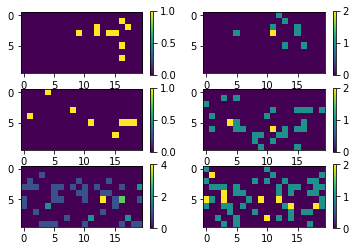

In [10]:
plt.figure()
for i in range(6):
  plt.subplot(3,2,i+1)
  plt.imshow(images[0,:,:,i])
  plt.colorbar()

In [65]:
np.amax(ima_re,axis=0)

array([3., 3., 3., ..., 3., 3., 4.])

In [0]:
label['Label'].values.shape

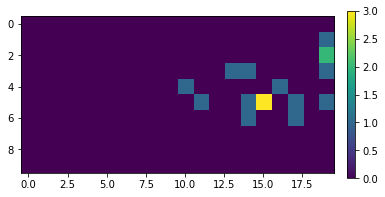

In [19]:
plt.figure()
plt.imshow(images[40000,:,:,0])
plt.colorbar(fraction=0.025, pad=0.04)

In [4]:
#c'è ordinamento dei dati
print(label.iloc[label.iloc[:,1].values==0])

        EventID  Label
39958   60001.0      0
39959   60002.0      0
39960   60004.0      0
39961   60005.0      0
39962   60007.0      0
...         ...    ...
79995  119993.0      0
79996  119994.0      0
79997  119996.0      0
79998  119997.0      0
79999  119998.0      0

[40042 rows x 2 columns]


In [85]:
## Modello per l'amico

inputs = keras.Input(IMG)
x= layers.Conv2D(64, (3, 3), padding='same')(inputs)
x = layers.ReLU()(x) #di base ReLU
x = layers.MaxPool2D(padding='same')(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(128,(2,3),padding='same')(x)
#x = layers.ReLU()(x)
x = layers.MaxPool2D((2,2),strides=(2,2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(256, (2, 2), padding='same')(x)
x = layers.ReLU()(x)
#x = layers.MaxPool2D((2,2))(x)
x= layers.Dropout(0.5)(x)

x = layers.Flatten()(x)

x = layers.Dense(512)(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(256)(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1,activation='sigmoid')(x)

model= keras.Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 10, 20, 6)]       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 10, 20, 64)        3520      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 5, 10, 64)         0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 5, 10, 64)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 5, 10, 128)        49280     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 2, 5, 128)         0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 2, 5, 128)         0  

In [86]:
model.compile(optimizer='adam',loss='binary_crossentropy',
              metrics='acc')
call= keras.callbacks.ModelCheckpoint(
    'best_w',
    monitor='val_acc',
    save_nest_only=True,
    save_weights_only=True
)

hystory=model.fit(images,label['Label'].values,batch_size=64,
                  epochs=70,validation_split=0.2,callbacks=call)

Epoch 1/70
1000/1000 [==============================] - 6s 6ms/step - loss: 0.5761 - acc: 0.7015 - val_loss: 0.6556 - val_acc: 0.7032
Epoch 2/70
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5281 - acc: 0.7358 - val_loss: 0.7726 - val_acc: 0.5526
Epoch 3/70
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5127 - acc: 0.7475 - val_loss: 0.8084 - val_acc: 0.5554
Epoch 4/70
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5053 - acc: 0.7506 - val_loss: 0.5105 - val_acc: 0.7903
Epoch 5/70
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5018 - acc: 0.7522 - val_loss: 0.7233 - val_acc: 0.6158
Epoch 6/70
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4946 - acc: 0.7570 - val_loss: 0.6578 - val_acc: 0.6719
Epoch 7/70
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4891 - acc: 0.7637 - val_loss: 0.7382 - val_acc: 0.5907
Epoch 8/70
1000/1000 [==============================] - 5s 5ms